In [140]:
import os
import sys
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

path_to_add = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if path_to_add not in sys.path:
    sys.path.insert(0, path_to_add)

from rsimpy.cmg.sr3reader import Sr3Reader

In [141]:
test_file = "../sr3/mini_section/base_case_bo_section.sr3"
sr3 = Sr3Reader(test_file)

# Cell Connections

In [142]:
def _get_connections(sr3):
    """Get all cell connections from the SR3 file.

    Returns:
    --------
    connections: np.ndarray
        Array with shape (n_connections, 3) where each row contains the two
        connected cells ("+" face and "-" face) and the connection type
        (1=I, 2=J, 3=K, 4=Mat-Frac). For connections with type 4, the
        cell order is matrix cell and fracture cell.
    """
    con_type = sr3.file.get_table("SpatialProperties/000000/GRID/ICNTDR")[:]
    cell1 = sr3.file.get_table("SpatialProperties/000000/GRID/ICTPS1")[:]
    cell2 = sr3.file.get_table("SpatialProperties/000000/GRID/ICTPS2")[:]

    cell1_ = sr3.grid.active2complete(cell1)
    cell2_ = sr3.grid.active2complete(cell2)

    ijk1 = sr3.grid.n2ijk(cell1_)
    ijk2 = sr3.grid.n2ijk(cell2_)

    con = np.min(np.stack([con_type, 3*np.ones_like(con_type)], axis=1), axis=1)
    downstream = ijk1[np.arange(ijk1.shape[0]),con-1] <= ijk2[np.arange(ijk2.shape[0]),con-1]

    connections = np.zeros((len(cell1_), 3), dtype=cell1_.dtype)
    connections[downstream] = np.column_stack((cell1_[downstream], cell2_[downstream], con_type[downstream]))
    connections[~downstream] = np.column_stack((cell2_[~downstream], cell1_[~downstream], con_type[~downstream]))

    return connections

connections = _get_connections(sr3)
connections

array([[3, 4, 2],
       [6, 3, 2],
       [3, 7, 3],
       [4, 8, 3],
       [5, 6, 2],
       [6, 7, 2],
       [7, 8, 2]], dtype=int32)

In [143]:
con_type = sr3.file.get_table("SpatialProperties/000000/GRID/ICNTDR")[:]

In [144]:
np.stack([con_type, con_type+2], axis=1)

array([[2, 4],
       [2, 4],
       [3, 5],
       [3, 5],
       [2, 4],
       [2, 4],
       [2, 4]], dtype=int32)

In [145]:
np.min(np.stack([con_type, 3*np.ones_like(con_type)], axis=1), axis=1)

array([2, 2, 3, 3, 2, 2, 2], dtype=int32)

In [146]:
cell1 = sr3.file.get_table("SpatialProperties/000000/GRID/ICTPS1")[:]
cell2 = sr3.file.get_table("SpatialProperties/000000/GRID/ICTPS2")[:]

cell1_ = sr3.grid.active2complete(cell1)
cell2_ = sr3.grid.active2complete(cell2)

ijk1 = sr3.grid.n2ijk(cell1_)
ijk2 = sr3.grid.n2ijk(cell2_)

In [147]:
sr3.grid.get_size()

{'ni': 1,
 'nj': 4,
 'nk': 2,
 'nijk': (1, 4, 2),
 'n_cells': 8,
 'n_matrix': 8,
 'n_fracture': 0,
 'n_active': 6,
 'n_active_matrix': 6,
 'n_active_fracture': 0}

In [148]:
np.stack([cell1_,cell2_,con_type],axis=1)

array([[3, 4, 2],
       [3, 6, 2],
       [3, 7, 3],
       [4, 8, 3],
       [5, 6, 2],
       [6, 7, 2],
       [7, 8, 2]], dtype=int32)

In [149]:
ijk1

array([[1, 3, 1],
       [1, 3, 1],
       [1, 3, 1],
       [1, 4, 1],
       [1, 1, 2],
       [1, 2, 2],
       [1, 3, 2]])

## Cell Coordinates

In [150]:
def _get_blocks_nodes(sr3):
    if sr3.file.get_table("SpatialProperties/000000/GRID/BLOCKS") is not None:
        blocks = sr3.file.get_table("SpatialProperties/000000/GRID/BLOCKS")[:].reshape(-1, 8)
        nodes = sr3.file.get_table("SpatialProperties/000000/GRID/NODES")[:].reshape(-1, 3)
        return blocks, nodes

    def _build_blocks(sr3):
        """Builds Blocks table for a regular grid."""
        ni = sr3.grid.get_size('ni')
        nj = sr3.grid.get_size('nj')
        nk = sr3.grid.get_size('nk')

        blocks = np.zeros((ni*nj*nk, 8), dtype=np.int32)

        ijk = sr3.grid.n2ijk(np.arange(1, ni*nj*nk+1))

        blocks[:, 0] = ijk[:,0] + (ijk[:,1]-1)*(ni+1) + (ijk[:,2]-1)*(ni+1)*(nj+1)
        blocks[:, 1] = blocks[:, 0] + 1
        blocks[:, 3] = blocks[:, 0] + ni + 1
        blocks[:, 2] = blocks[:, 3] + 1
        blocks[:, 4] = blocks[:, 0] + (ni+1)*(nj+1)
        blocks[:, 5] = blocks[:, 4] + 1
        blocks[:, 7] = blocks[:, 4] + ni + 1
        blocks[:, 6] = blocks[:, 7] + 1

        if sr3.grid.get_size('n_cells') > ni*nj*nk:
            blocks = np.concatenate([blocks, blocks])
        return blocks

    def _build_nodes(sr3):
        """Builds Nodes table for a regular grid."""
        ni = sr3.grid.get_size('ni')
        nj = sr3.grid.get_size('nj')
        nk = sr3.grid.get_size('nk')

        nodes = np.zeros(((ni+1)*(nj+1)*(nk+1),3), dtype=np.float64)

        x_coord = sr3.file.get_table("SpatialProperties/000000/GRID/XCORNCRCN")[:]
        y_coord = sr3.file.get_table("SpatialProperties/000000/GRID/YCORNCRCN")[:]
        z_coord = sr3.file.get_table("SpatialProperties/000000/GRID/ZCORNCRCN")[:]

        nodes[:,0] = x_coord
        nodes[:,1] = y_coord
        nodes[:,2] = z_coord

        return nodes

    blocks = _build_blocks(sr3)
    nodes = _build_nodes(sr3)

    return blocks, nodes

In [151]:
blocks, nodes = _get_blocks_nodes(sr3)

In [152]:
EPSILON = 1 # m
Z_SCALE = 100 # eps_z = eps/z_scale

In [153]:
def get_scaled_norm(vector, z_scale=Z_SCALE, axis=1):
    """
    Calculate the norm of a vector with the z-direction coordinates scaled by a given factor.

    Parameters:
    vector (numpy.ndarray): An array of shape ([n], 3) representing 3D coordinates.
    z_scale (float): The scaling factor for the z-direction coordinates.
    axis (int): The axis along which to compute the norm.

    Returns:
    numpy.ndarray: An array of ([n]) norms.
    """
    vector_array = vector.reshape(-1, 3)
    vector_array[:, 2] *= z_scale

    return np.linalg.norm(vector, axis=axis)

In [154]:
def _get_nodes(cell, face=None):
    """Get coordinates of nodes of a cell or cells.

    The cell numbering is as follows:
                K-
            0--------1            x--> I
           /|       /|           /|
          / |      / |          / |
         /  |  J- /  |         v  v
        3--------2   |        J   K
        |   |    |   |
    I-  |   4----|---5  I+
        |  / J+  |  /
        | /      | /
        |/       |/
        7--------6
           K+

    Nodes are ordered in the faces so that the normal vector points
    in the same direction as the coordinate system.

    Parameters
    ----------
    cell : int, list of int or np.ndarray
        Cell number(s) (complete).
    face : int, str or None
        Face of the cell. If None, all nodes of the cell are returned.
        Valid values are "I-", "I+", "J-", "J+", "K-", "K+", or
        0, 1, 2, 3, 4, 5 for I-, I+, J-, J+, K-, K+, respectively.

    Returns
    -------
    np.ndarray
        Coordinates of nodes of the cell(s).
    """
    if isinstance(cell, (int, np.integer)):
        cell = np.array([cell])
    elif isinstance(cell, list):
        cell = np.array(cell)

    if face is None:
        edge_n = [0, 1, 2, 3, 4, 5, 6, 7]
    elif face == "I-" or face==0:
        edge_n = [3, 7, 4, 0]
    elif face == "I+" or face==1:
        edge_n = [2, 6, 5, 1]
    elif face == "J-" or face==2:
        edge_n = [0, 4, 5, 1]
    elif face == "J+" or face==3:
        edge_n = [3, 7, 6, 2]
    elif face == "K-" or face==4:
        edge_n = [0, 1, 2, 3]
    elif face == "K+" or face==5:
        edge_n = [4, 5, 6, 7]
    else:
        raise ValueError(f"Invalid face: {face}.")

    return nodes[blocks[cell-1][:,edge_n]-1]

_get_nodes([4,3], "I-")

array([[[1913.0129, 9194.1446, 5472.3262],
        [1913.0129, 9194.1446, 5472.3262],
        [1934.5569, 9392.1485, 5505.0625],
        [1934.6487, 9392.085 , 5503.563 ]],

       [[1934.6487, 9392.085 , 5503.563 ],
        [1934.5569, 9392.1485, 5505.0625],
        [1956.3928, 9590.9219, 5539.4429],
        [1956.468 , 9590.8692, 5538.2178]]])

In [155]:
def _get_center(cell, face=None):
    return np.mean(_get_nodes(cell, face), axis=1)

_get_center([4,3], "I-")

array([[1923.80785 , 9293.130675, 5488.319475],
       [1945.5166  , 9491.50615 , 5521.57155 ]])

In [156]:
def _get_intersection(line1, line2, tolerance=EPSILON):
    """
    Find the closest point between two lines in 3D.

    Parameters:
    line1, line2: Lines defined by two points. (numpy arrays of shape (2, 3))

    Returns:
    closest_point: The closest point to both lines (numpy array of shape (3,))
    """
    p1 = line1[0]
    p2 = line2[0]
    d1 = line1[1] - line1[0]
    d2 = line2[1] - line2[0]

    d1 = d1 / np.linalg.norm(d1)
    d2 = d2 / np.linalg.norm(d2)
    cross_d1_d2 = np.cross(d1, d2)

    cross_d1_d2_norm = np.linalg.norm(cross_d1_d2)
    if cross_d1_d2_norm < 1E-6:
        raise ValueError("The lines are parallel and do not intersect.")

    p2_p1 = p2 - p1

    t1 = np.linalg.det([p2_p1, d2, cross_d1_d2]) / cross_d1_d2_norm**2
    t2 = np.linalg.det([p2_p1, d1, cross_d1_d2]) / cross_d1_d2_norm**2

    closest_point_on_line1 = p1 + t1 * d1
    closest_point_on_line2 = p2 + t2 * d2

    if get_scaled_norm(closest_point_on_line1 - closest_point_on_line2, axis=0) > tolerance:
        raise ValueError("The lines are skew and do not intersect.")

    closest_point = (closest_point_on_line1 + closest_point_on_line2) / 2
    return closest_point

In [157]:
def _get_nnc_face(face1, face2):
    """Get the coordinates of the nodes of the non-neighbor connection face."""

    if len(face1.shape) == 3:
        face1 = face1[0]
    if len(face2.shape) == 3:
        face2 = face2[0]

    if np.all(get_scaled_norm(face1 - face2, axis=1) < EPSILON):
        return face1

    faces = np.stack((face1, face2), axis=0)

    limits = faces[0][:,2] > faces[1][:,2]

    top_left = faces[1-limits[0]][0]
    bottom_left = faces[0+limits[1]][1]
    bottom_right = faces[0+limits[2]][2]
    top_right = faces[1-limits[3]][3]

    checks = [
        top_left[2] <= bottom_left[2],
        limits[0] != limits[3],
        top_right[2] <= bottom_right[2],
        limits[1] != limits[2],
    ]

    if not np.any(checks):
        raise ValueError("Faces are not connected.")

    face_nodes = []
    if checks[0]:
        face_nodes.append(bottom_left)
        face_nodes.append(top_left)
    else:
        face_nodes.append(_get_intersection(
            faces[1-limits[0]][[0,3]],
            faces[0+limits[1]][[1,2]]
            ))

    if checks[1]:
        face_nodes.append(_get_intersection(
            faces[0][[0,3]],
            faces[1][[0,3]]
            ))

    if checks[2]:
        face_nodes.append(top_right)
        face_nodes.append(bottom_right)
    else:
        face_nodes.append(_get_intersection(
            faces[0+limits[2]][[1,2]],
            faces[1-limits[3]][[0,3]]
            ))

    if checks[3]:
        face_nodes.append(_get_intersection(
            faces[0][[1,2]],
            faces[1][[1,2]]
            ))

    return np.stack(face_nodes, axis=0)

In [158]:
def _get_common_face(connection):
    cell1, cell2, con_type = connection

    face1_index = 2*con_type - 1
    face2_index = 2*con_type - 2

    face1 = _get_nodes(cell1, face1_index)
    face2 = _get_nodes(cell2, face2_index)

    return _get_nnc_face(face1, face2)

_get_common_face(connections[1])

array([[1797.92898881, 9610.09537679, 5531.81233636],
       [1761.4953    , 9614.4776    , 5529.3247    ],
       [1761.4494    , 9614.5098    , 5530.0557    ]])

In [159]:
for c in connections:
    print(c)
    print(_get_common_face(c))

[3 4 2]
[[1934.6487 9392.085  5503.563 ]
 [1934.5569 9392.1485 5505.0625]
 [1739.3762 9416.4063 5496.6265]
 [1739.5813 9416.2911 5494.1958]]
[6 3 2]
[[1797.92898881 9610.09537679 5531.81233636]
 [1761.4953     9614.4776     5529.3247    ]
 [1761.4494     9614.5098     5530.0557    ]]
[3 7 3]
[[1956.3928 9590.9219 5539.4429]
 [1761.4494 9614.5098 5530.0557]
 [1739.3762 9416.4063 5496.6265]
 [1934.5569 9392.1485 5505.0625]]
[4 8 3]
[[1934.5569 9392.1485 5505.0625]
 [1739.3762 9416.4063 5496.6265]
 [1718.5998 9218.0801 5464.9932]
 [1913.0129 9194.1446 5472.3262]]
[5 6 2]
[[1978.2463 9791.2598 5583.7827]
 [1978.2463 9791.2598 5583.7827]
 [1782.4367 9813.5372 5572.1289]
 [1782.5637 9813.4493 5570.1582]]
[6 7 2]
[[1956.0842     9591.1368     5544.4429    ]
 [1956.1965     9591.0567     5542.6187    ]
 [1797.92898881 9610.09537679 5531.81233636]
 [1761.4494     9614.5098     5530.0557    ]
 [1761.133      9614.7325     5535.0557    ]]
[7 8 2]
[[1934.5569 9392.1485 5505.0625]
 [1934.2531 9392.

In [160]:
_get_common_face((3,4,2))

array([[1934.6487, 9392.085 , 5503.563 ],
       [1934.5569, 9392.1485, 5505.0625],
       [1739.3762, 9416.4063, 5496.6265],
       [1739.5813, 9416.2911, 5494.1958]])

In [161]:
def _get_plane_properties(points, add_areas=False, include_center=False):
    """
    Calculate the normal vector of the plane defined by the given 3D points.

    Parameters:
    points (np.array): A numpy array of shape (n, 3) containing the 3D coordinates of the points.
    add_areas (bool): If True, the function will rescale the mean normal vector by the sum of the
      areas of the triangles.
    include_center (bool): If True, the function will return the center of the points.

    Returns:
    np.array: The normal vector of the plane (3,) or the center and normal vector stacked (2,3).
    """
    center = np.mean(points, axis=0)

    normal_vectors = []
    closed_coordinates = np.vstack([points, points[0]])
    for pa, pb in zip(closed_coordinates[:-1], closed_coordinates[1:]):
        normal = np.cross(pa-center, pb-center) / 2
        normal_vectors.append(normal)

    normal_vector = np.sum(normal_vectors, axis=0)
    if add_areas:
        total_area = np.sum(np.linalg.norm(normal_vectors, axis=1))
        normal_vector = normal_vector / np.linalg.norm(normal_vector) * total_area

    if include_center:
        return np.stack((center, normal_vector), axis=0)
    return normal_vector

In [162]:
for c in connections:
    face = _get_common_face(connections[6])
    normal = _get_plane_properties(face)
    a1 = np.linalg.norm(normal)

    normal = _get_plane_properties(face, add_areas=True)
    a2 = np.linalg.norm(normal)
    print(f'Area error {c}: {100*(a1/a2-1):0.4f}%')

Area error [3 4 2]: -0.0001%
Area error [6 3 2]: -0.0001%
Area error [3 7 3]: -0.0001%
Area error [4 8 3]: -0.0001%
Area error [5 6 2]: -0.0001%
Area error [6 7 2]: -0.0001%
Area error [7 8 2]: -0.0001%


In [163]:
def _get_ad_dd(connections, add_areas=False):
    """Calculates the a.d/d.d ratio for each side of the given connections.

    a is the normal of the area common to the two cell faces.
    d is the distance between the center of the cell and the center of the
    corresponding face.

    Parameters:
    connections (np.ndarray): Array of shape (n_connections, 3) where each row
        contains the two connected cells ("+" face and "-" face) and the
        connection type (1=I, 2=J, 3=K, 4=Mat-Frac). For connections with
        type 4, the cell order is matrix cell and fracture cell.
    add_areas (bool): If True, the function will rescale the mean normal vector
        by the sum of the areas of the triangles.

    Returns:
    np.ndarray: Array of shape (n_connections, 2) containing the a.d/d.d ratio
        for each side of the connections.
    """
    cell_centers = np.stack([
        _get_center(connections[:,0]),
        _get_center(connections[:,1])
        ], axis=1)
    con_type = np.stack([
        2*connections[:,2]-1,
        2*connections[:,2]-2
        ], axis=1)

    con_array = connections[:,[0,1]].reshape(-1)
    con_type_array = con_type.reshape(-1)

    faces = np.zeros([cell_centers.shape[0], 2, 4, 3])
    faces_array = faces.reshape(-1,4,3)
    for i in range(6):
        filter_ = con_type_array == i
        if np.any(filter_):
            faces_array[filter_] = _get_nodes(con_array[filter_], i)

    face_centers = np.zeros_like(cell_centers)
    face_centers_array = face_centers.reshape(-1, 3)
    face_centers_array[:] = np.mean(faces_array, axis=1)

    normals = np.array([
        _get_plane_properties(_get_nnc_face(f[0],f[1]), add_areas) for f in faces
        ])

    di = face_centers - cell_centers
    di = np.abs(di)

    normals = np.abs(normals)
    normals = np.stack([normals]*2, axis=1)
    ad = np.sum(di * normals, axis=2)
    dd = np.sum(di * di, axis=2)

    return ad/dd

_get_ad_dd(connections[[3,6]])

array([[4.37771209e+04, 1.58102509e+04],
       [9.66698721e+00, 9.70668362e+00]])

## Plotting 3D Planes

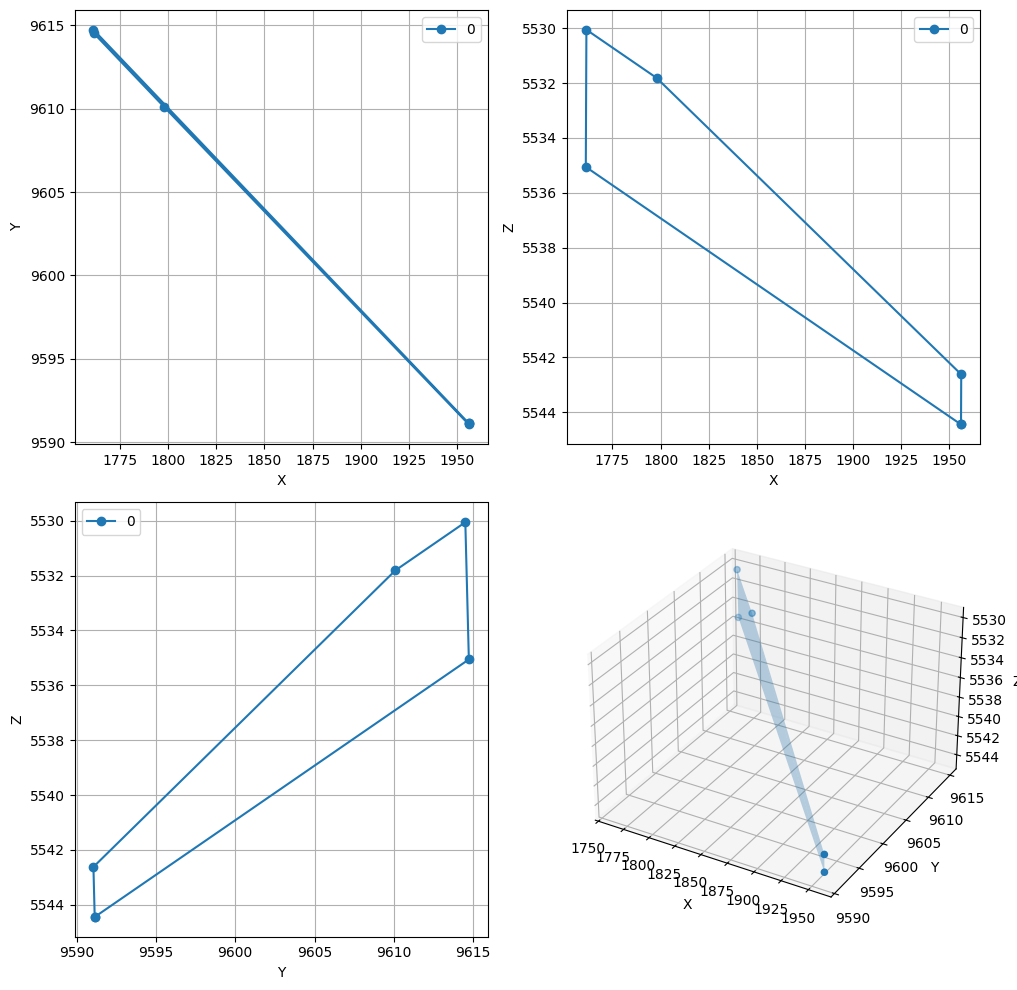

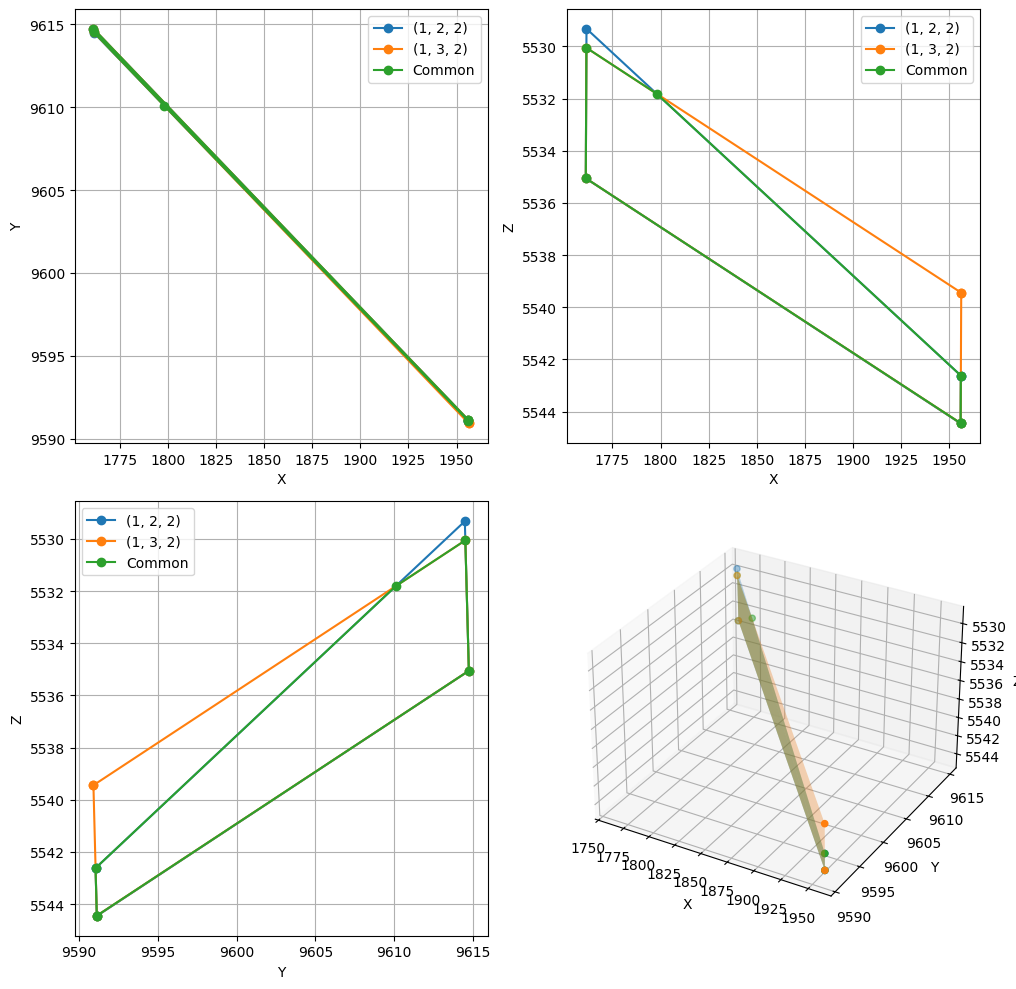

In [164]:
def plot_planes(faces, labels=None):
    fig, axis = plt.subplots(2, 2, figsize=(10, 10))
    axis = axis.flatten()

    def plot_face(ax, coordinates, x_axis=0, y_axis=1,
                  x_axis_label='X', y_axis_label='Y', label=None,
                  invert_yaxis=False):
        closed_coordinates = np.vstack([coordinates, coordinates[0]])
        ax.plot(closed_coordinates[:, x_axis], closed_coordinates[:, y_axis], marker='o', label=label)
        ax.set_xlabel(x_axis_label)
        ax.set_ylabel(y_axis_label)
        if invert_yaxis:
            ax.invert_yaxis()
        ax.grid(True)
        ax.legend()

    x_axis = [0, 0, 1]
    y_axis = [1, 2, 2]
    x_axis_label = ['X', 'X', 'Y']
    y_axis_label = ['Y', 'Z', 'Z']

    for x, y, x_label, y_label, ax in zip(x_axis, y_axis, x_axis_label, y_axis_label, axis[:3]):
        for i,face in enumerate(faces):
            if labels is not None:
                label = str(labels[i])
            else:
                label = f'{i}'
            if len(face.shape) == 3:
                face = face[0]
            plot_face(ax, face, x, y, x_label, y_label, label, invert_yaxis=(y_label=='Z'))

    for spine in axis[-1].spines.values():
        spine.set_visible(False)
    axis[-1].grid(False)
    axis[-1].set_xticks([])
    axis[-1].set_yticks([])

    def plot_3d(ax, coordinates):
        if len(coordinates.shape) == 3:
            coordinates = coordinates[0]
        x = coordinates[:, 0]
        y = coordinates[:, 1]
        z = coordinates[:, 2]

        # x and y arrays must consist of at least 3 unique points
        # if len(np.unique(coordinates[:,[0,1]], axis=0)) > 2:
        try:
            ax.plot_trisurf(x, y, z, alpha=0.3)
        except Exception as e:
            print(e)

        ax.scatter(x, y, z, marker='o')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ax.set_box_aspect([1.0, 1.0, 0.7])
        ax.invert_zaxis()

    ax_3d = fig.add_subplot(2, 2, 4, projection='3d')
    for face in faces:
        plot_3d(ax_3d, face)

    plt.tight_layout()
    plt.show()


def plot_connection(connection):
    face1 = _get_nodes(connection[0], 2*connection[-1]-1)
    face2 = _get_nodes(connection[1], 2*connection[-1]-2)
    common = _get_common_face(connection)
    plot_planes(
        faces=[face1, face2, common],
        labels=[
            sr3.grid.n2ijk(connection[0]),
            sr3.grid.n2ijk(connection[1]),
            "Common"])


coordinates = _get_common_face(connections[5])
plot_planes(coordinates.reshape(1,-1,3))

# coordinates = _get_nodes([4], "I-")
# plot_planes(coordinates, [sr3.grid.n2ijk(4)])

plot_connection(connections[5])

## Mini 3D model

In [165]:
test_file = "../sr3/dat_mini3d_hard/mini3d_hard.sr3"
sr3 = Sr3Reader(test_file)
connections = _get_connections(sr3)
blocks, nodes = _get_blocks_nodes(sr3)

In [166]:
errors = []
for c in connections:
    try:
        x = _get_common_face(c)
    except ValueError as e:
        cells = sr3.grid.n2ijk(c[0:2])
        errors.append(f'{c[0]} {cells[0]} and {c[1]} {cells[1]} in {c[2]}: {e}')
if len(errors) == 0:
    print("All connections are correct.")
else:
    print('\n'.join(errors))

All connections are correct.


x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.


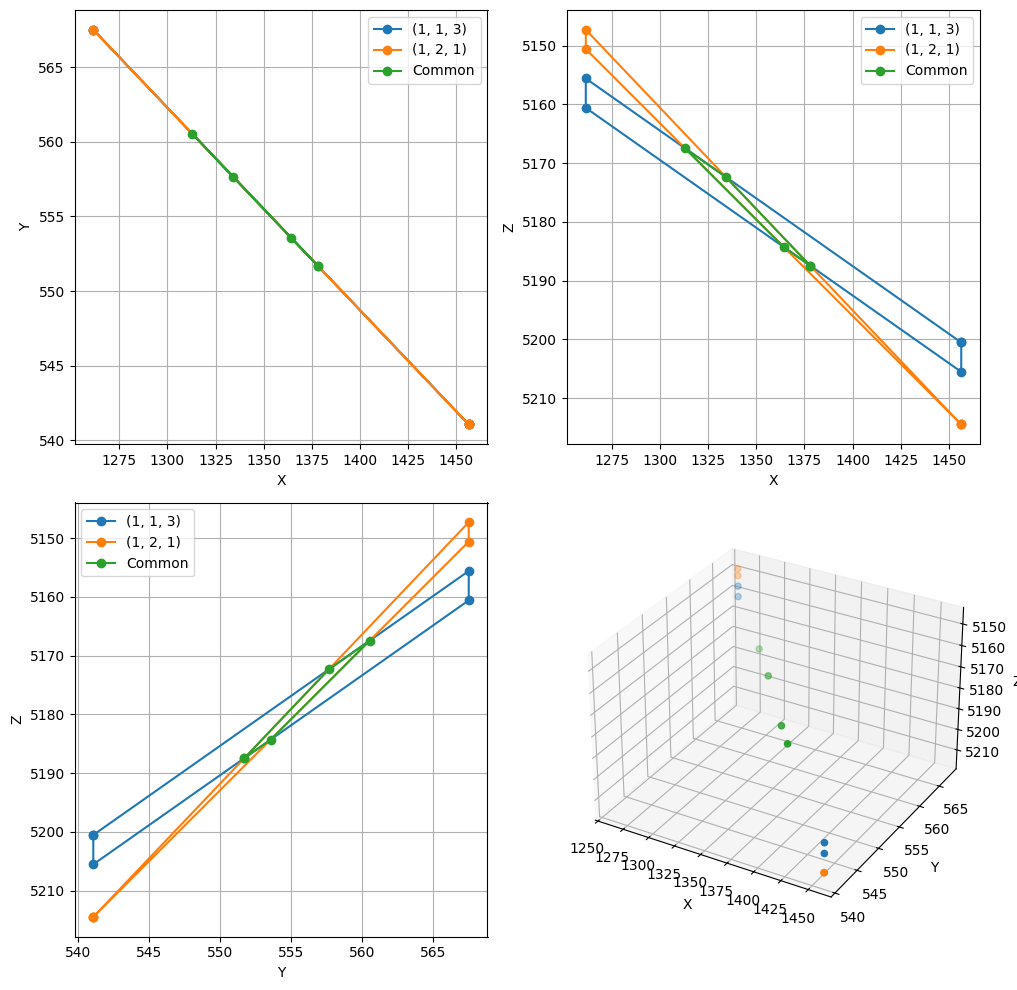

In [167]:
plot_connection(connections[4])

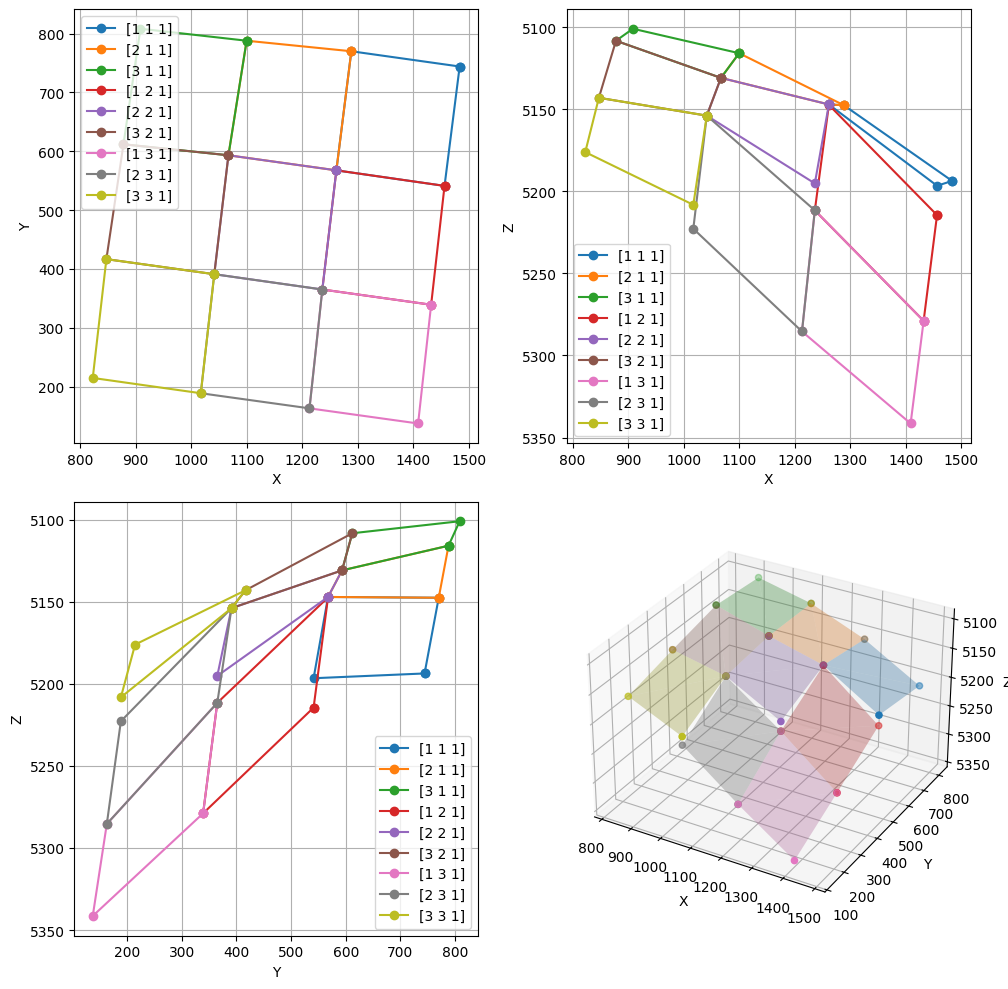

x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points


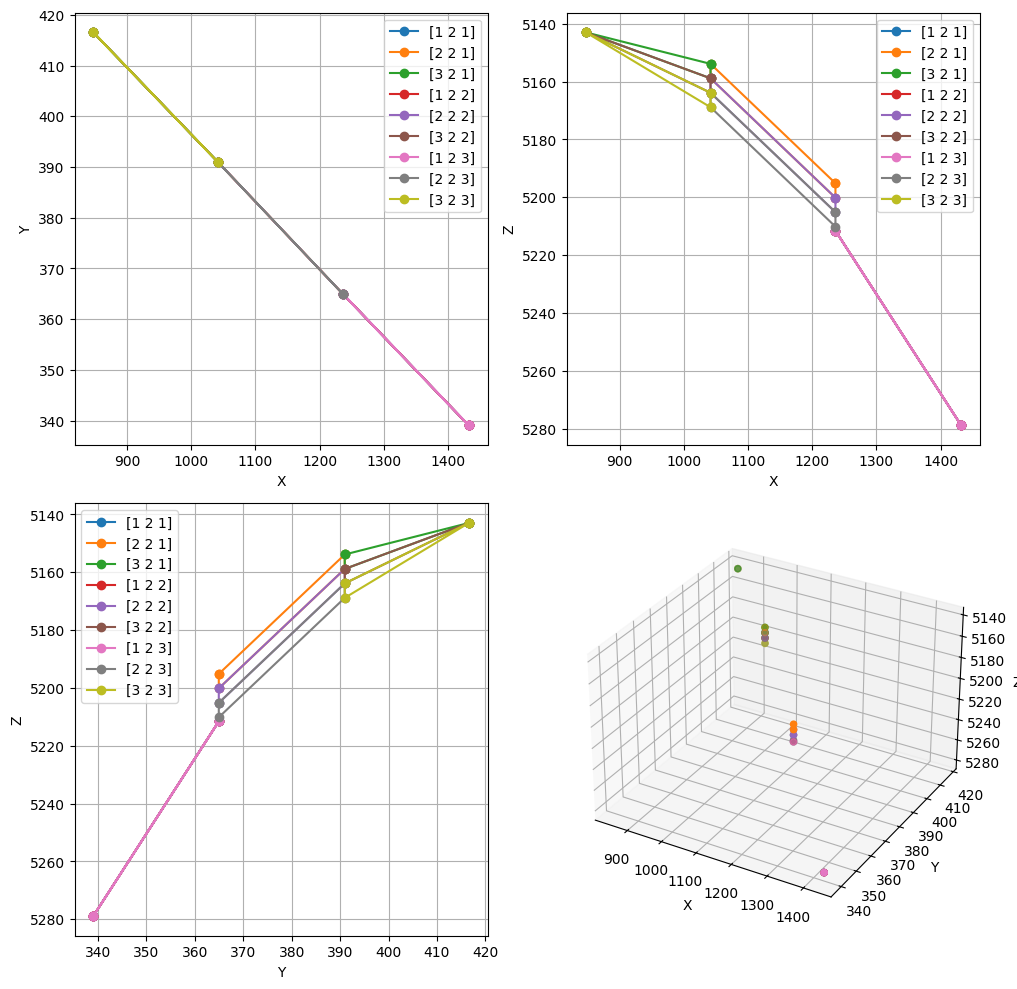

x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points
x and y arrays must consist of at least 3 unique points


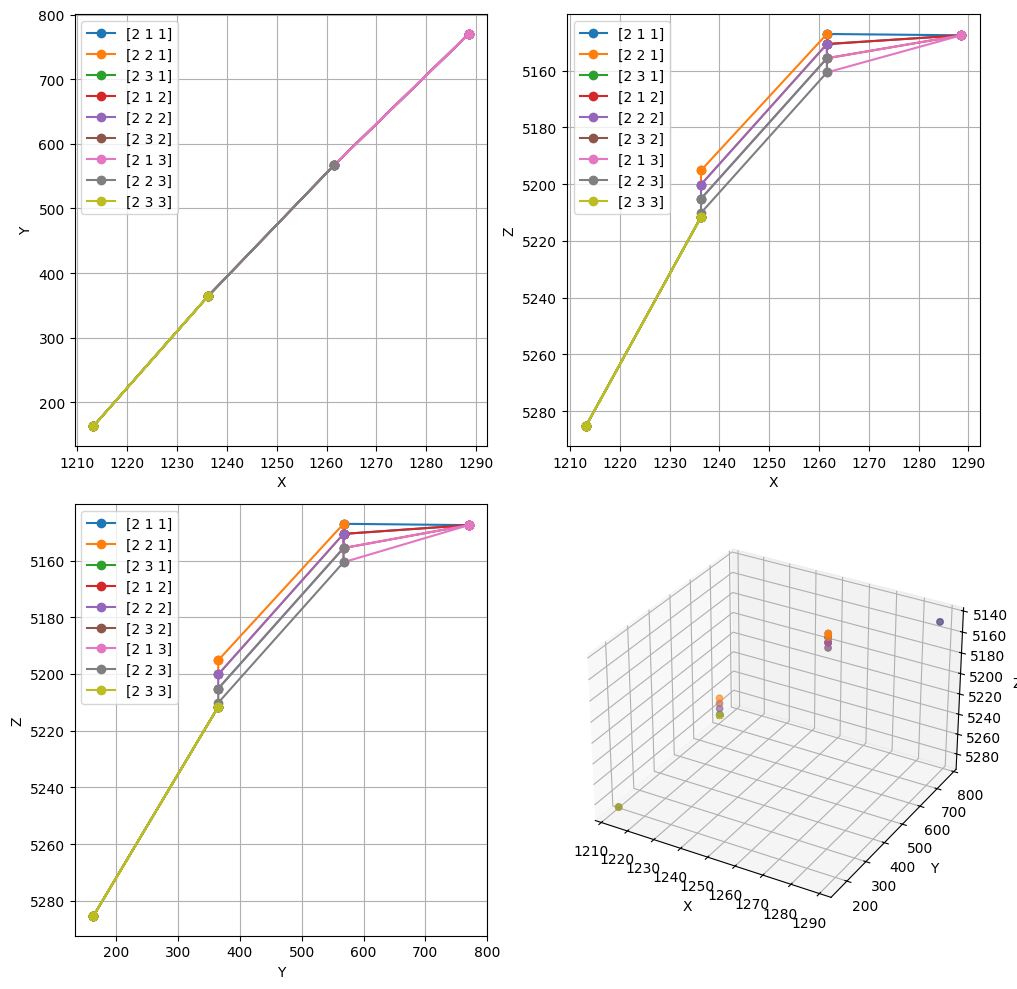

In [168]:
nodes_ = [1,2,3,4,5,6,7,8,9]
coordinates = _get_nodes(nodes_, "K-")
plot_planes(coordinates, sr3.grid.n2ijk(nodes_))

nodes_ = [4,5,6, 13,14,15, 22,23,24]
coordinates = _get_nodes(nodes_, "J+")
plot_planes(coordinates, sr3.grid.n2ijk(nodes_))

nodes_ = [2,5,8, 11,14,17, 20,23,26]
coordinates = _get_nodes(nodes_, "I-")

plot_planes(coordinates, sr3.grid.n2ijk(nodes_))

## Bigger Model

In [169]:
test_file = "../sr3/base_case_3a.sr3"
sr3 = Sr3Reader(test_file)
blocks, nodes = _get_blocks_nodes(sr3)
connections = _get_connections(sr3)
print(f'{len(connections):,} connections')

176,572 connections


In [170]:
errors = []
for c in connections:
    try:
        x = _get_common_face(c)
    except ValueError as e:
        cells = sr3.grid.n2ijk(c[0:2])
        errors.append(f'{c[0]} {cells[0]} and {c[1]} {cells[1]} in {c[2]}: {e}')
if len(errors) == 0:
    print(f"All {len(connections):,} connections are correct.")
else:
    print(f'{len(errors)} errors found.')
    print('\n'.join(errors))

All 176,572 connections are correct.


x and y arrays must consist of at least 3 unique points


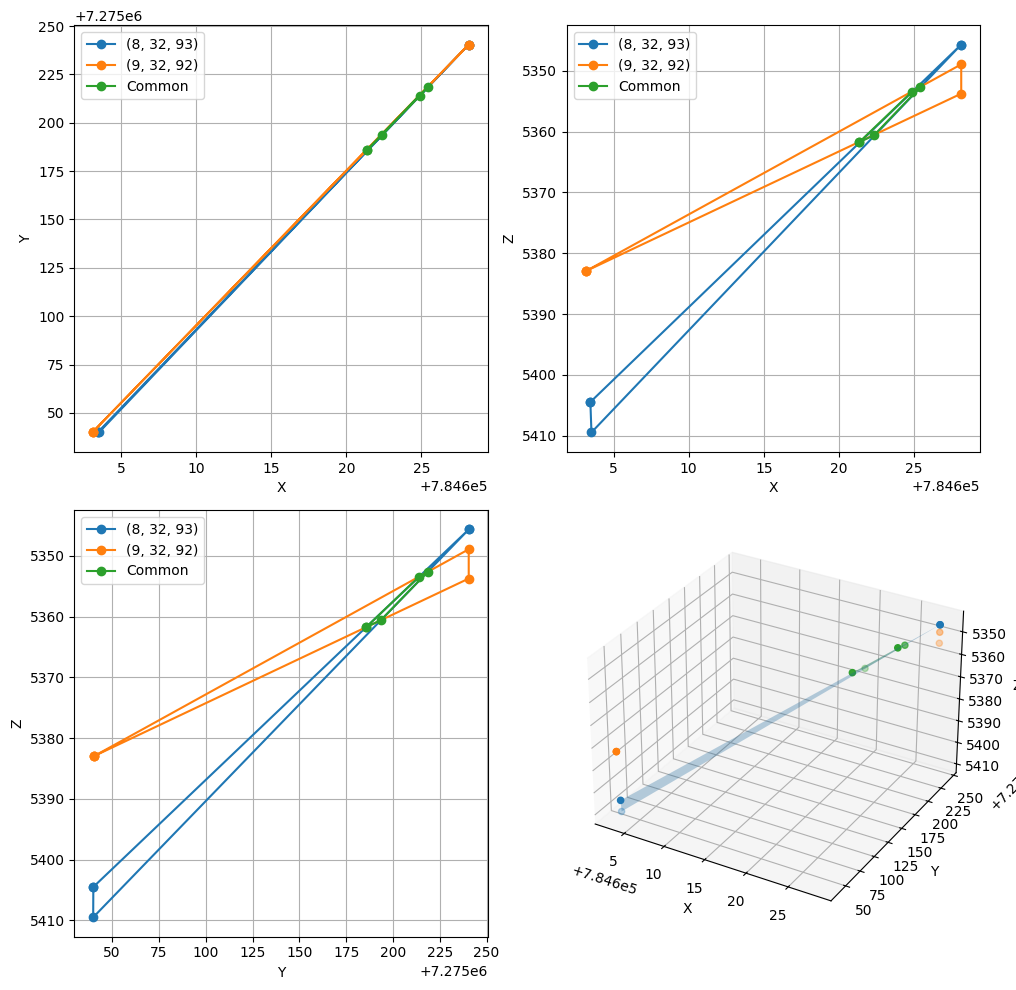

In [171]:
plot_connection([170101, 168269, 1])

## Simple Model

In [172]:
test_file = "../sr3/dat_mini3d/mini3d.sr3"
sr3 = Sr3Reader(test_file)
blocks, nodes = _get_blocks_nodes(sr3)

In [173]:
connections = _get_connections(sr3)
print(f'{len(connections):,} connections')

20 connections


In [174]:
errors = []
for c in connections:
    try:
        x = _get_common_face(c)
    except ValueError as e:
        cells = sr3.grid.n2ijk(c[0:2])
        errors.append(f'{c[0]} {cells[0]} and {c[1]} {cells[1]} in {c[2]}: {e}')
if len(errors) == 0:
    print(f"All {len(connections):,} connections are correct.")
else:
    print(f'{len(errors)} errors found.')
    print('\n'.join(errors))

All 20 connections are correct.


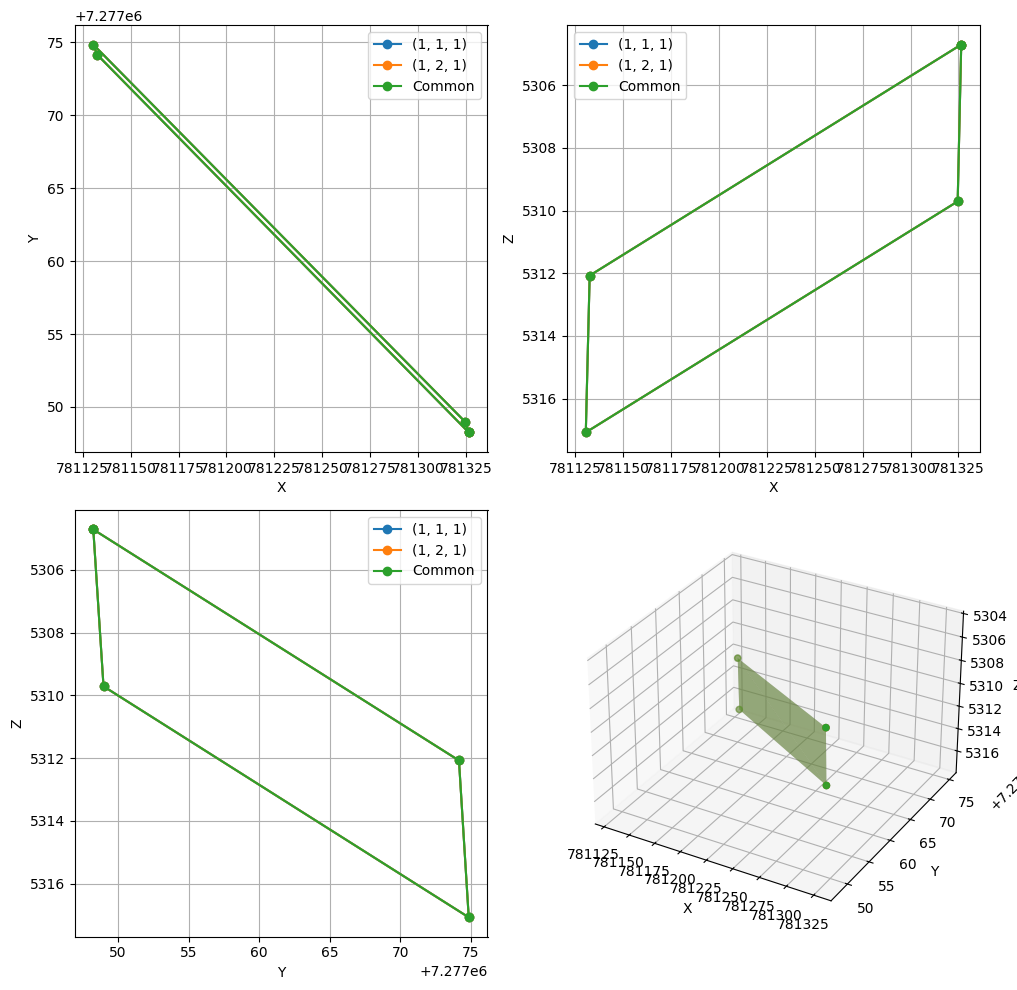

In [175]:
plot_connection(connections[1])

## Example 3

In [176]:
test_file = "../sr3/imex_2phi2k.sr3"
sr3 = Sr3Reader(test_file)
blocks, nodes = _get_blocks_nodes(sr3)
connections = _get_connections(sr3)
print(f'{len(connections):,} connections')

23 connections


## TODO

* Solve 2phi2k connection coeficcient (type 4?6?).